In [ ]:
'''
First pass analysis to see if data dimensionality changes between A and not A.
Uses PCA.ratio_explained_variance for the heavy lifting.
Even makes a pretty plot at the end.
Created by Yoni Browning, August 2018
'''

In [305]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
%matplotlib inline
import scipy as sp
import numpy as np
import pandas as pd
# sometimes order maters on these
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import oBehave.plotting_stuff as obps
import oBehave.helperfunctions as obhf
import oBehave.neural_analysis as obna
import oBehave.behavior_analysis as obba
import sklearn.decomposition as decomp


from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.utilities import get_trace_around_timepoint,get_nearest_frame
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

#experiment_id = 639438856# experiment B
experiment_id = 639253368

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
# include novel sessions in manifest...stops use from looking at data where mouse has seem not A stims before
manifest = obhf.load_manifest()
obba.includeNovelSession(manifest);
#dataset= VisualBehaviorOphysDataset(experiment_id=experiment_id, cache_dir=obhf.drive_path)
#analysis = ResponseAnalysis(dataset)

In [229]:
# compute data dimensionality...taken streight out of Eric's talk...
def computeEricsDimension(dataset,analysis):
    dataset= VisualBehaviorOphysDataset(experiment_id=rows.experiment_id, cache_dir=obhf.drive_path)
    analysis = ResponseAnalysis(dataset)
    num_trials = len(dataset.stimulus_table)
    fr = killnancells(dataset,analysis)
    use_cells = np.unique(fr.cell)
    response_array = np.empty((num_trials,len(use_cells)))
    for i in range(num_trials):
        response_array[i,:] = fr[fr.flash_number==i].mean_response.values
    PCA = decomp.PCA()
    X = PCA.fit(response_array-response_array.mean())
    D = 1/sum((PCA.explained_variance_ratio_)**2.)
    return D

In [316]:
# some quality control. This should be added to a more general package.
def killnancells(dataset,analysis):
    bad_cell_indices = []
    bad_cell_ids = []
    for cell_index in range(dataset.dff_traces.shape[0]):
        if np.isnan(dataset.dff_traces[cell_index][0]): #check whether first datapoint is nan
           bad_cell_indices.append(cell_index)
           bad_cell_ids.append(dataset.get_cell_specimen_id_for_cell_index(cell_index))
    fdf = analysis.flash_response_df.copy()
    fdf = fdf[fdf.cell.isin(bad_cell_indices)==False]
    return fdf

In [318]:
# Do dimensionality computation for all novel sessions
keylist = ['experiment_id','session_type','targeted_structure','cre_line','dimension']
dim = {k:[]for k in keylist}
for ii, rows in manifest.iterrows():
    if rows.first_session:
        dataset= VisualBehaviorOphysDataset(experiment_id=rows.experiment_id, cache_dir=obhf.drive_path)
        analysis = ResponseAnalysis(dataset)
        num_trials = len(dataset.stimulus_table)
        fr = killnancells(dataset,analysis)
        use_cells = np.unique(fr.cell)
        response_array = np.empty((num_trials,len(use_cells)))
        for i in range(num_trials):
            response_array[i,:] = fr[fr.flash_number==i].mean_response.values
        PCA = decomp.PCA()
        X = PCA.fit(response_array-response_array.mean())
        D = 1/sum((PCA.explained_variance_ratio_)**2.)
        ##
        dim['experiment_id'].append(rows.experiment_id)
        dim['session_type'].append(rows.session_type)
        dim['targeted_structure'].append(rows.targeted_structure)
        dim['cre_line'].append(rows.cre_line)
        dim['dimension'].append(D)
        print(rows.session_type+','+ rows.cre_line  +','+rows.targeted_structure+ ' : ' + str(dim['dimension'][-1]))

loading trial response dataframe
loading flash response dataframe
behavior_session_A,Vip-IRES-Cre,VISp : 3.22914068049
loading trial response dataframe
loading flash response dataframe
behavior_session_B,Vip-IRES-Cre,VISp : 1.79559554164
loading trial response dataframe
loading flash response dataframe
behavior_session_C,Vip-IRES-Cre,VISp : 2.69973565741
loading trial response dataframe
loading flash response dataframe
behavior_session_D,Vip-IRES-Cre,VISp : 3.74252931569
loading trial response dataframe
loading flash response dataframe
behavior_session_A,Vip-IRES-Cre,VISp : 2.15108419538
loading trial response dataframe
loading flash response dataframe
behavior_session_B,Vip-IRES-Cre,VISp : 3.31502929996
loading trial response dataframe
loading flash response dataframe
behavior_session_C,Vip-IRES-Cre,VISp : 4.54282828751
loading trial response dataframe
loading flash response dataframe
behavior_session_D,Vip-IRES-Cre,VISp : 4.54961460061
loading trial response dataframe
loading flash r

In [319]:
DimFrame = pd.DataFrame(dim)

Text(0.5,1,'VIP, VISal')

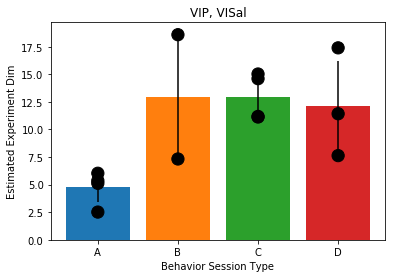

In [397]:
# make a pretty plot :)
behs = ['behavior_session_A','behavior_session_B','behavior_session_C','behavior_session_D']
scat = []
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
for ii,s in enumerate(behs):
    this_data = DimFrame[(DimFrame.targeted_structure=='VISp')
                         &(DimFrame['cre_line']=='Slc17a7-IRES2-Cre')#'Vip-IRES-Cre')#'Vip-IRES-Cre')#
                         &(DimFrame['session_type']==s)]['dimension'].values
    scat.append(this_data)
    #print(this_data)
    plt.scatter(ii*np.ones((len(this_data),1)),this_data,color = 'K',marker = 'o',zorder = 3,s = [150]*len(this_data))#np.oness((len(this_data),)))
    plt.bar(ii,np.mean(this_data),yerr = sp.std(this_data),color = colorlist[ii])
plt.xticks([0,1,2,3],['A','B','C','D'])
plt.ylabel('Estimated Experiment Dim')
plt.xlabel('Behavior Session Type')
plt.title('Slc, VISp')

In [380]:
# some sanity checks
mm = obba.includeNovelSession(manifest)
mm[(mm.cre_line == 'Slc17a7-IRES2-Cre')&(mm.session_type == 'behavior_session_C')&(mm.first_session==True)&(mm.targeted_structure=='VISp')]

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date,experiment_datetime,first_session
12,653053906,652784528,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_C,333706,597617440,12/12/2017 12:33,2017-12-12 12:00:33,True
16,639769395,639001089,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_C,334310,599659785,10/2/2017 12:49,2017-10-02 12:00:49,True
25,672584839,670266085,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_C,355471,644831080,3/13/2018 10:47,2018-03-13 10:00:47,True
27,686726085,682951696,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_C,369316,657448350,4/19/2018 10:41,2018-04-19 10:00:41,True
